## Hybrid Models
>We use hybrid models to combine difernt habilities to our predictions

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [2]:
url = 'https://raw.githubusercontent.com/PauloFS01/dataframes/main/us-retail-sales.csv'
industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    url,
    usecols=['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)

In [3]:
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)
retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

## Linear Regression Model
> we use LR model here couse it can learn trend will and give us multoutput

In [4]:
y = retail.copy()

dp = DeterministicProcess(
    index=y.index,
    order=2,
    constant=True,
    drop=True,
)
X = dp.in_sample()

# separate ids from train and test sets
idx_train, idx_test = train_test_split(y.index, test_size=48, shuffle=False)

X_train = X.loc[idx_train,:]
X_test = X.loc[idx_test,:]

y_train= y.loc[idx_train]
y_test = y.loc[idx_test]

# fit and predictions
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)

y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

/tmp/ipykernel_16244/1312323473.py:2: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
/tmp/ipykernel_16244/1312323473.py:3: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
/tmp/ipykernel_16244/1312323473.py:4: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)


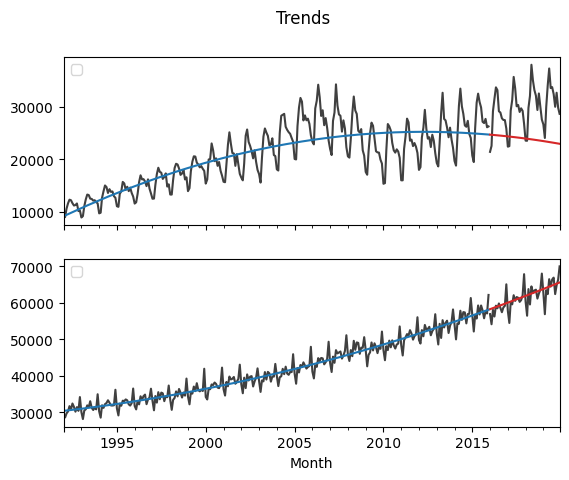

In [5]:
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

## XGBoost Algorithm
> XGBoost cant give us multi output so we need convert the series to wide format

In [4]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')  # grab target series

/tmp/ipykernel_4975/1944929637.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X = retail.stack()  # pivot dataset wide to long


Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

Label encolding

In [29]:
X = X.reset_index('Industries')

for colname in X.select_dtypes(["object", "category"]):
    X[colname],_ = X[colname].factorize()

# create a kind of encode for anual seasonality (1...12)
X['Month'] = X.index.month

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

Now we need wide trend prediction and subtract then to from original series in order to have detrended series

In [ ]:
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

Create and fit Xgboost

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

Add the predicted residuals onto the predicted trends

In [36]:
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

## Plot

/tmp/ipykernel_16244/2192305118.py:5: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.unstack(['Industries']).plot(
/tmp/ipykernel_16244/2192305118.py:8: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit_boosted.unstack(['Industries']).plot(
/tmp/ipykernel_16244/2192305118.py:11: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred_boosted.unstack(['Industries']).plot(


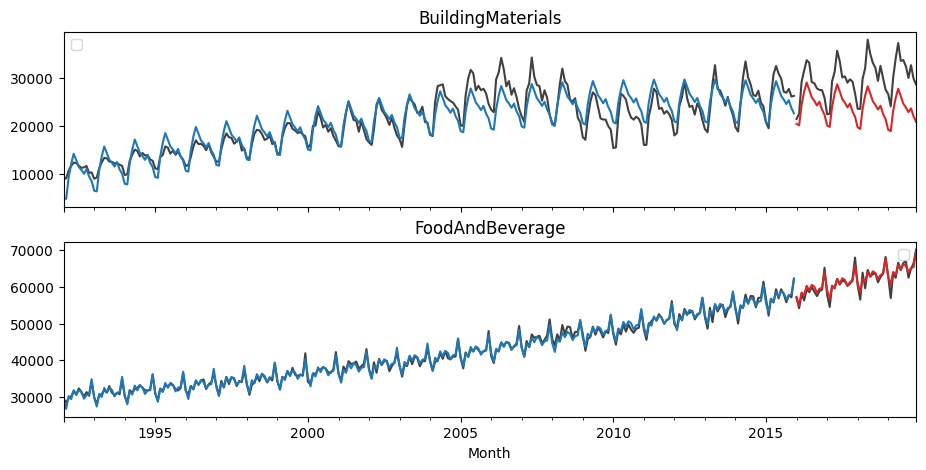

In [37]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

XGBoost wasn't able to compensate for the poorly fit trend in the 'BuildingMaterials' series.